<a href="https://colab.research.google.com/github/vjhawar12/Vision-Transformer-paper-implementation/blob/main/notebook/Vision_Transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale

In [5]:
!git clone https://github.com/vjhawar12/Vision-Transformer-paper-implementation.git
%cd Vision-Transformer-paper-implementation

Cloning into 'Vision-Transformer-paper-implementation'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 140 (delta 70), reused 57 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (140/140), 248.43 KiB | 2.53 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/Vision-Transformer-paper-implementation


In [6]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from dataloader import get_dataloaders
from scheduler_func import sched_func
from transforms import get_transforms
from train_utils import train, validate
from test_utils import test
from torchvision.transforms.v2 import CutMix, MixUp, RandomChoice
from vit_model import PatchEmbedding, ManualMultiHeadSelfAttention, TransformerEncoder, VisionTransformer
from data import data
from dataset import get_training_data, get_test_data
from timm.loss import SoftTargetCrossEntropy
from torch.optim.lr_scheduler import LambdaLR
from pprint import pprint

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Variable initialization

In [7]:
with open("hyperparams.json", "r") as f:
    params = json.load(f)
    pprint(params)

{'alpha': 0.25,
 'batchsize': 512,
 'channels': 3,
 'cutmix_or_mixup_start': 20,
 'dropout': 0.05,
 'embeddim': 252,
 'encoders': 8,
 'epochs': 100,
 'imsize': 64,
 'max_cutmix_or_mixup': 0.5,
 'max_mixup': 0.5,
 'mixup_start': 10,
 'numclasses': 10,
 'numheads': 12,
 'patchsize': 4}


In [8]:
train_transform, test_transform = get_transforms()

training_data = get_training_data(train_transform)
test_data = get_test_data(test_transform)

100%|██████████| 170M/170M [00:03<00:00, 53.4MB/s]


In [9]:
train_dataloader, test_dataloader = get_dataloaders(training_data, test_data, params['batchsize'])

In [10]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
sft_loss_fn = SoftTargetCrossEntropy()

scaler = torch.amp.GradScaler()

cutmix = CutMix(num_classes=params['numclasses'])
mixup = MixUp(num_classes=params['numclasses'], alpha=params['alpha'])

# CUDA optimizations

In [11]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)

# Model creation

In [12]:
vit = torch.compile(VisionTransformer(
    batches=params['batchsize'], in_channels=params['channels'],
    patch_size=params['patchsize'], embed_dim=params['embeddim'],
    heads=params['numheads'], depth=params['encoders'], size=params['imsize'],
    num_classes=params['numclasses']
  ))

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)

OptimizedModule(
  (_orig_mod): VisionTransformer(
    (patch_embedding): PatchEmbedding(
      (proj): Conv2d(3, 252, kernel_size=(4, 4), stride=(4, 4))
    )
    (transformer_stack): ModuleList(
      (0-7): 8 x TransformerEncoder(
        (mhsa): ManualMultiHeadSelfAttention(
          (Q_proj): Linear(in_features=252, out_features=252, bias=True)
          (V_proj): Linear(in_features=252, out_features=252, bias=True)
          (K_proj): Linear(in_features=252, out_features=252, bias=True)
          (dropout): Dropout(p=0.15, inplace=False)
          (output): Linear(in_features=252, out_features=252, bias=True)
        )
        (ln1): LayerNorm((252,), eps=1e-05, elementwise_affine=True)
        (drop_path_1): DropPath(drop_prob=0.050)
        (drop_path_2): DropPath(drop_prob=0.050)
        (ffn): Sequential(
          (0): Linear(in_features=252, out_features=252, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Lin

In [14]:
optim = torch.optim.AdamW(vit.parameters(), lr=1e-3, weight_decay=0.05)
scheduler = LambdaLR(optim, lr_lambda=sched_func)

# Train and validation set loop

In [15]:
train_acc = []
val_acc = []
lr = []
losses = []

for i in range(params['epochs']):
    torch.cuda.empty_cache()
    vit.train(True)

    loop = tqdm(train_dataloader, desc=f"Epoch {i+1}/{params['epochs']}", leave=True, disable=False)

    total, correct, loss = train(
        vit, device, params['cutmix_or_mixup_start'],
        params['mixup_start'], params['max_cutmix_or_mixup'],
        params['max_mixup'], optim, mixup, cutmix,
        sft_loss_fn, loss_fn, scaler, i, loop,
    )

    val_total, val_correct = validate(vit, test_dataloader, device)

    val_accuracy = val_correct / val_total
    accuracy = correct / total

    current_lr = optim.param_groups[0]['lr']

    losses.append(loss)
    lr.append(current_lr)
    train_acc.append(accuracy)
    val_acc.append(val_accuracy)

    print(f"Epoch {i + 1}: LR={current_lr:.6f} \t Train Acc: {accuracy:.4f} \t Val Acc: {val_accuracy:.4f}")

Epoch 1/100:   0%|          | 0/98 [00:46<?, ?it/s]


UnboundLocalError: cannot access local variable 'running_loss' where it is not associated with a value

# Test set loop

In [ ]:
vit.eval()
correct, total = test()
accuracy = correct / total

print(f"Accuracy: {accuracy}")

# Per-epoch loss graph

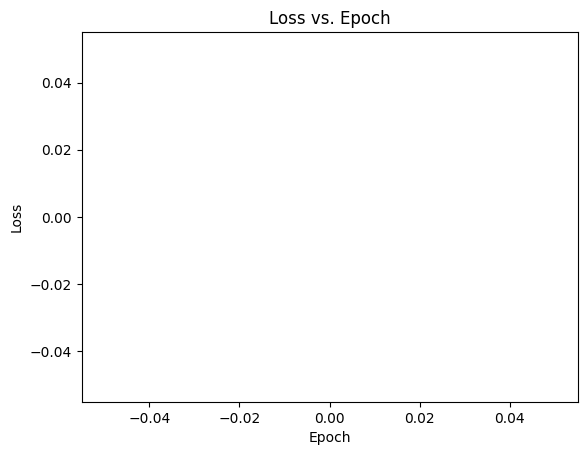

In [16]:
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(losses)

# Per-epoch LR graph

In [ ]:
plt.title("Learning Rate vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")

plt.plot(lr)

# Per-epoch Training vs Validation set accuracy

In [ ]:
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Val")

plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")


plt.legend()

# Data table

In [ ]:
df = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)
df.transpose()

## 📊 Final Results

- **Dataset**: CIFAR-10
- **Model**: Vision Transformer (ViT)
- **Paper**: [An Image is Worth 16x16 Words (Dosovitskiy et al.)](https://arxiv.org/abs/2010.11929)
- **Training Epochs**: 100
- **Batch Size**: 512  
- **Optimizer**: AdamW  
- **Learning Rate**: 0.003 with 0.05 weight decay
- **Train Accuracy**: 87.2%
- **Test Accuracy**: 85.7%

